# TF-IDF & Cosine Similarity

## Libraries, Globals & Config

In [28]:
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np 
import io 
import re

filters = [
         "lowercase.txt", "asciifolding.txt",
         "stop.txt", "snowball.txt",
         "porterstem.txt","kstem.txt"
          ]

tokenizers = [
               "whitespace.txt", "classic.txt",
               "standard.txt", "letter.txt"
             ]

## ElasticSearch Filters & Tokenizers Tests

In [29]:
filters_word_count = {}
tokenizers_word_count = {}
get_numbers_pattern = r"^\d+"

for test in (filters+tokenizers):
        last_line_of_doc = open(f"./count_tests/{test}", "r").readlines()[-1]
        match = re.match(get_numbers_pattern, last_line_of_doc)
        #IF the line is in another format this will cause a possible exception or just a None value
        if test in filters:
                filters_word_count[test] = int(match.group())
        else:
                tokenizers_word_count[test] = int(match.group())
                
#Sort both dictionaries in ascending order
filters_word_count = dict(sorted(filters_word_count.items(), key=lambda x:x[1]))
tokenizers_word_count = dict(sorted(tokenizers_word_count.items(), key=lambda x:x[1]))

    

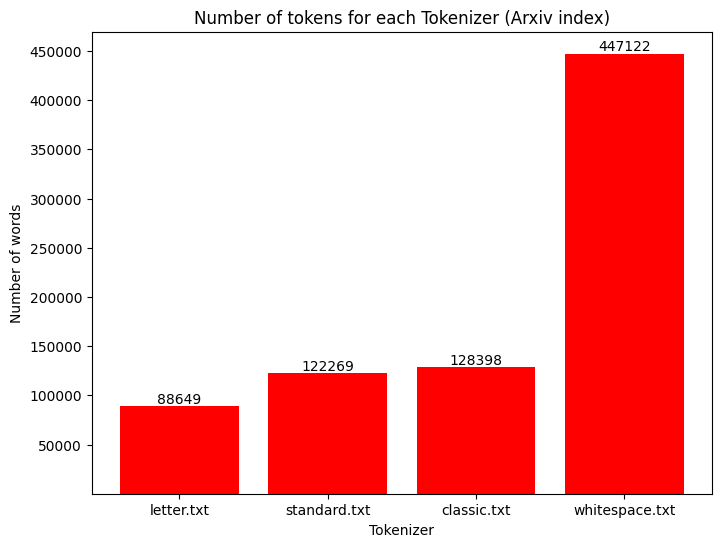

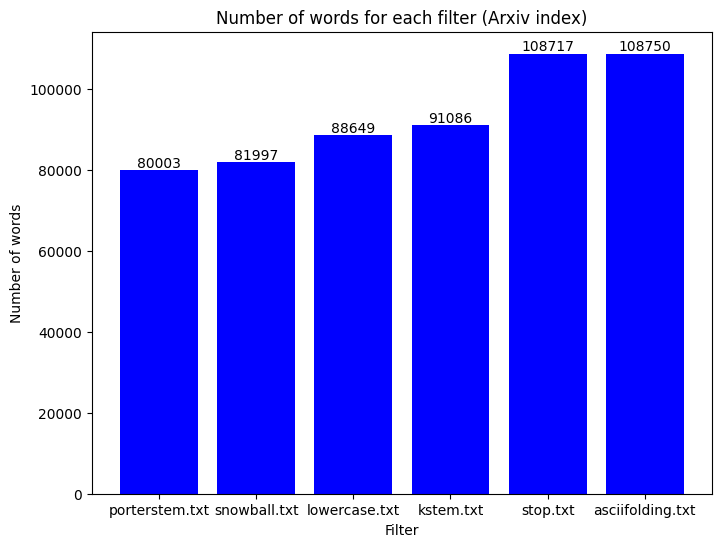

In [34]:
# Plot for different type of tokenizers
plt.figure(figsize=(8,6))
plt.bar(tokenizers_word_count.keys(), tokenizers_word_count.values(), color="red")
for i, v in enumerate(tokenizers_word_count.values()):
    plt.text(i, v + 1, str(v), ha='center', va='bottom')
    
plt.title("Number of tokens for each Tokenizer (Arxiv index)")
plt.xlabel("Tokenizer")
plt.ylabel("Number of words")
plt.ylim(bottom=0)
plt.yticks(ticks=[50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000,450000])
plt.show()


# Plot for different type of filters
plt.figure(figsize=(8,6))
plt.bar(filters_word_count.keys(), filters_word_count.values(), color="blue")
for i, v in enumerate(filters_word_count.values()):
    plt.text(i, v + 1, str(v), ha='center', va='bottom')
    
plt.title("Number of words for each filter (Arxiv index)")
plt.xlabel("Filter")
plt.ylabel("Number of words")
plt.ylim(bottom=0)
plt.show()


## TF-IDF Implementation
### Index I/O

In [ ]:


from elasticsearch import Elasticsearch
from elasticsearch.exceptions import NotFoundError
from elasticsearch.client import CatClient
from elasticsearch_dsl import Search
from elasticsearch_dsl.query import Q

import argparse

import numpy as np

__author__ = 'bejar'

def search_file_by_path(client, index, path):
    """
    Search for a file using its path

    :param path:
    :return:
    """
    s = Search(using=client, index=index)
    q = Q('match', path=path)  # exact search in the path field
    s = s.query(q)
    result = s.execute()

    lfiles = [r for r in result]
    if len(lfiles) == 0:
        raise NameError(f'File [{path}] not found')
    else:
        return lfiles[0].meta.id


def document_term_vector(client, index, id):
    """
    Returns the term vector of a document and its statistics a two sorted list of pairs (word, count)
    The first one is the frequency of the term in the document, the second one is the number of documents
    that contain the term

    :param client:
    :param index:
    :param id:
    :return:
    """
    termvector = client.termvectors(index=index, id=id, fields=['text'],
                                    positions=False, term_statistics=True)

    file_td = {}
    file_df = {}

    if 'text' in termvector['term_vectors']:
        for t in termvector['term_vectors']['text']['terms']:
            file_td[t] = termvector['term_vectors']['text']['terms'][t]['term_freq']
            file_df[t] = termvector['term_vectors']['text']['terms'][t]['doc_freq']
    return sorted(file_td.items()), sorted(file_df.items())

def doc_count(client, index):
    """
    Returns the number of documents in an index

    :param client:
    :param index:
    :return:
    """
    return int(CatClient(client).count(index=[index], format='json')[0]['count'])



### TF-IDF function


In [57]:
def toTFIDF(client, index, file_id):
    """
    Returns the term weights of a document

    :param file:
    :return:
    """

    # Get the frequency of the term in the document, and the number of documents
    # that contain the term
    #file_tv dictionary of (term, howmanyaparitions in doc) , (term, howmanydocumentscontain)
    file_tv, file_df = document_term_vector(client, index, file_id)

    max_freq = max([f for _, f in file_tv])

    document_count = doc_count(client, index)

    tfidfw = []
    #Where t is term, w is count, df is document-frequency
    for (t, w),(_, df) in zip(file_tv, file_df):
        
        term_frequency = w / max_freq 
        inverse_document_frequency = np.log2(document_count / df)
        #append weigth[i,d] of term i and document d 
        tfidfw.append((t,term_frequency * inverse_document_frequency))

    return normalize(tfidfw)

### Utilities for TF-IDF

In [58]:
def print_term_weigth_vector(twv):
    """
    Prints the term vector and the correspondig weights
    :param twv:
    :return:
    """
    for (term,weight) in twv:
        print(f"({term},{weight})")
    

def normalize(tw):
    """
    Normalizes the weights in t so that they form a unit-length vector
    It is assumed that not all weights are 0
    :param tw:
    :return:
    """
    summ = 0
    for (term, tfidf) in tw: 
        summ += tfidf**2 
    norm = np.sqrt(summ)
        
    return [(term,tfidf/norm) for (term,tfidf) in tw]

#We assume that tw1 & tw2 are going to be sorted alphabetically
def cosine_similarity(tw1, tw2):
    """
    Computes the cosine similarity between two weight vectors, terms are alphabetically ordered
    :param tw1:
    :param tw2:
    :return:
    """
    pointer_tw1 = 0
    pointer_tw2 = 0
    dot_product = 0
    while pointer_tw1 < len(tw1) and pointer_tw2 < len(tw2):
        (term1, weight1) = tw1[pointer_tw1]
        (term2, weight2) = tw2[pointer_tw2] 
        
        if term1 == term2:
            dot_product += weight1 * weight2
            pointer_tw1 += 1
            pointer_tw2 += 1
            
        elif term1 < term2: 
            pointer_tw1 += 1
        #term2 < term1
        else:
            pointer_tw2 += 1
            
    return dot_product


In [56]:
import numpy as np
print_term_weigth_vector([("norml", 1), ("maricon", 1), ("falda", 1)])

(norml,1)
(maricon,1)
(falda,1)


### Main program & testing

In [ ]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--index', default=None, required=True, help='Index to search')
    parser.add_argument('--files', default=None, required=True, nargs=2, help='Paths of the files to compare')
    parser.add_argument('--print', default=False, action='store_true', help='Print TFIDF vectors')

    args = parser.parse_args()


    index = args.index

    file1 = args.files[0]
    file2 = args.files[1]

    client = Elasticsearch(timeout=1000)

    try:

        # Get the files ids
        file1_id = search_file_by_path(client, index, file1)
        file2_id = search_file_by_path(client, index, file2)

        # Compute the TF-IDF vectors
        file1_tw = toTFIDF(client, index, file1_id)
        file2_tw = toTFIDF(client, index, file2_id)

        if args.print:
            print(f'TFIDF FILE {file1}')
            print_term_weigth_vector(file1_tw)
            print ('---------------------')
            print(f'TFIDF FILE {file2}')
            print_term_weigth_vector(file2_tw)
            print ('---------------------')

        print(f"Similarity = {cosine_similarity(file1_tw, file2_tw):3.5f}")

    except NotFoundError:
        print(f'Index {index} does not exists')